# Evaluation of divmakers models

In this notebook we evaluate the performance of models trained using the divmakers repository - using SimCLR and Divmaker objectives

to use this notebook you need the `divmaker` environment - python 3.9 is required

In [1]:
import os
import torch
from pathlib import Path
import sys
sys.path.append("..")

In [2]:
import numpy as np
import pandas as pd
from time import time
from tqdm import tqdm
from pathlib import Path


In [3]:
import os
from osgeo import gdal
import imageio
import numpy as np

from time import time
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


In [4]:
import os
from copy import deepcopy
import src.systems as systems
from src.utils.utils import load_json
from src.utils.setup import process_config
import random, torch, numpy
import torch.multiprocessing
torch.multiprocessing.set_sharing_strategy('file_system')

from pathlib import Path


import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
import wandb

torch.backends.cudnn.benchmark = True

SYSTEM = {
    'PretrainSystem': systems.PretrainSystem,
    'PretrainDivMakerSystem': systems.PretrainDivMakerSystem,
    'LinearSystem': systems.LinearSystem,
    'DefaultSystem': systems.DefaultSystem,
    'TransferSystem': systems.TransferSystem,
    'TransferBigEarthNetSystem': systems.TransferBigEarthNetSystem,
    'TransferDefaultSystem': systems.TransferDefaultSystem,
}

In [19]:
def load_from_config(config_str, checkpoint_name=None):
    gpu_device = 0
    
    if gpu_device == 'cpu' or not gpu_device:
        gpu_device = None
    config = process_config(config_str)
    if gpu_device: 
        config.gpu_device = gpu_device
    SystemClass = SYSTEM[config.system]

    system = SystemClass(config)

    if config.optim_params.scheduler:
            lr_callback = globals()[config.optim_params.scheduler](
                initial_lr=config.optim_params.learning_rate,
                max_epochs=config.num_epochs,
                schedule=(
                    int(0.6*config.num_epochs),
                    int(0.8*config.num_epochs),
                ),
            )
            callbacks = [lr_callback]
    else:
        callbacks = []

    ckpt_callback = pl.callbacks.ModelCheckpoint(
        os.path.join(config.exp_dir, 'checkpoints'),
        save_top_k=-1,
        every_n_epochs=1,
    )
    callbacks.append(ckpt_callback)
    
    gpu_device = 1
    
    if gpu_device: config.gpu_device = gpu_device

    callbacks.append(ckpt_callback)
    wandb_logger = WandbLogger(project='image_viewmaker', name=config.exp_name, config=config, sync_tensorboard=True)
    trainer = pl.Trainer(
            default_root_dir=config.exp_dir,
            gpus=gpu_device,
            max_epochs=config.num_epochs,
            min_epochs=config.num_epochs,
            checkpoint_callback=True,
            resume_from_checkpoint=config.continue_from_checkpoint,
            precision=config.optim_params.precision or 32,
            callbacks=callbacks,
            val_check_interval=config.val_check_interval or 1.0,
            limit_val_batches=config.limit_val_batches or 1.0,
            logger=wandb_logger,
        )
    
    if checkpoint_name:
        ckpt_path = Path(config.checkpoint_dir) / checkpoint_name
    else:   
        ckpt_path = Path(config.checkpoint_dir) / config.pretrain_model.checkpoint_name
    
    SystemClass = SYSTEM[config.system]
    
    system = SystemClass.load_from_checkpoint(ckpt_path, config=config)

        
    system.cuda()
    system.eval()
    return system

In [6]:
cuda = torch.cuda.is_available()

def create_embeddings_divmaker(model, 
                               dataset,
                               z_dim=512):
      

    X = np.zeros((len(dataset), z_dim))
    y = np.zeros(len(dataset))
    
    t0 = time()
    # this solution to iterate over examples is very suboptimal, one should use torch dataset
    for index, item in enumerate(tqdm(dataset)):
        # read the tile from provided filepath
        
        
        tile = item[0].unsqueeze(0)
        if cuda: 
            tile = tile.cuda()
            
        
        z = model.model(tile)
        if cuda: 
            z = z.cpu()
        z = z.data.numpy()
        y[index] = item[1]
        X[index,:] = z

    t1 = time()
    print('Embedded {} tiles: {:0.3f}s'.format(len(dataset), t1-t0))
    
    return X, y

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()

rf = RandomForestClassifier()

def compare_results(X, y, model, folds = 5, model_name = ""):
    # simple method to evaluate performance of model using cross validation
    if model_name == "":
        model_name = model.__class__.__name__
    
    scores = cross_val_score(rf, X, y, cv=folds)
    print("Averaged accuracy for model {}: {:.2f}±{:.2f}%".format(model_name, scores.mean()*100, scores.std()*100))

In [62]:
from sklearn.cluster import KMeans
from sklearn.metrics import completeness_score, homogeneity_score, v_measure_score
from sklearn.metrics import silhouette_score

def compare_results_kmeans(X, y, kmeans=None, n_folds = 5, model_name = ""):
    if kmeans is None:
        kmeans = KMeans(n_clusters = 10)

    idx = np.arange(len(y))
    idx = np.random.permutation(idx) % n_folds

    silhouette = []
    v_measures = []

    for i in range(n_folds):
        X_train = X[idx != i]
        y_train = y[idx != i]
        X_test = X[idx == i]
        y_test = y[idx == i]

        kmeans.fit(X_train, y_train)
        y_pred = kmeans.predict(X_test)
        v_measures.append(v_measure_score(y_test, y_pred))
        silhouette.append(completeness_score(y_test, y_pred))
        
    print("Averaged vmeasure for model: {:.2f}±{:.2f}".format(np.mean(v_measures), np.std(v_measures)))
    print("Averaged silhouette for model: {:.2f}±{:.2f}".format(np.mean(silhouette), np.std(silhouette)))


In [69]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import json

def vizualize_tsne_2d(X:np.ndarray, y:np.ndarray, text = "", **kwargs) -> None:
    # create tsne
    tsne = TSNE(n_components=2, **kwargs)
    tsne_result = tsne.fit_transform(X)

    tsne_result = pd.DataFrame(tsne_result)
    tsne_result

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    label_map = ['label_map.json', 'AnnualCrop', 'train.csv', 'Highway', 'HerbaceousVegetation', 'test.csv', 'Industrial', 'validation.csv', 'River', 'Pasture', 'Residential', 'PermanentCrop', 'Forest', 'SeaLake']
    reverse_label_map = {idx:k for idx, k in enumerate(label_map)}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig,ax = plt.subplots()
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,lab = (plot_data.loc[plot_data['label']==label,0],plot_data.loc[plot_data['label']==label,1],plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    print(np.unique(y_valtest_text))
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


def vizualize_tsne_3d(X:np.ndarray, y:np.ndarray, text = "", **kwargs) -> None:
    # create tsne
    tsne = TSNE(n_components=3, **kwargs)
    tsne_result = tsne.fit_transform(X)
    tsne_result = pd.DataFrame(tsne_result)

    # create dataframe to plot
    plot_data = pd.concat([pd.DataFrame(tsne_result), pd.DataFrame(y, columns=['label'])], axis = 1)

    # change numbers to meaningful text labels
    label_map = ['label_map.json', 'AnnualCrop', 'train.csv', 'Highway', 'HerbaceousVegetation', 'test.csv', 'Industrial', 'validation.csv', 'River', 'Pasture', 'Residential', 'PermanentCrop', 'Forest', 'SeaLake']
    reverse_label_map = {idx:k for idx, k in enumerate(label_map)}
    reverse_label_map

    y_valtest_text = pd.Series(y).map(reverse_label_map)

    # plot tsne
    fig = plt.figure()
    ax = fig.add_subplot(projection = "3d")
    for label in np.unique(plot_data['label']).tolist():
        x_plot,y_plot,z_plot,lab = (plot_data.loc[plot_data['label']==label,0],
                    plot_data.loc[plot_data['label']==label,1],
                    plot_data.loc[plot_data['label']==label,2],
                    plot_data.loc[plot_data['label']==label,'label'])
        ax.scatter(x_plot, y_plot, z_plot, label = lab)
    ax.set_title(f"TSNE on tile2vec ({text})")
    ax.legend(np.unique(y_valtest_text), title = "Labels", bbox_to_anchor = (1.1,1.05))


In [8]:
from src.datasets import datasets

In [65]:
config_str = "config/eurosat/default_eurosat_simclr_eval.json"

config = process_config(config_str)

system = load_from_config(config_str, checkpoint_name="epoch=199-step=17199.ckpt")

[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories s

Loaded configuration: 
{'continue_from_checkpoint': None,
 'copy_checkpoint_freq': 5,
 'cuda': True,
 'data_loader_workers': 16,
 'data_params': {'dataset': 'eurosat',
                 'default_augmentations': 'all',
                 'resize_imagenet_to_32': True},
 'distributed_backend': 'dp',
 'exp_base': '/storage/divmaker/',
 'exp_name': 'pretrain_eurosat_simclr',
 'gpu_device': 0,
 'loss_params': DotMap(t=0.07, name='simclr'),
 'model_params': {'num_res_blocks': 3,
                  'out_dim': 512,
                  'projection_head': False,
                  'resnet': True,
                  'resnet_small': True,
                  'resnet_version': 'resnet18'},
 'num_epochs': 200,
 'optim_params': {'batch_size': 256,
                  'learning_rate': 0.03,
                  'momentum': 0.9,
                  'num_view_update': 1,
                  'patience': 10,
                  'validate_freq': 1,
                  'weight_decay': 0.0001},
 'pretrain_model': {'checkpoint_name

/home/tymek/.conda/envs/divmaker/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /storage/divmaker/experiments/pretrain_eurosat_simclr/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [66]:
train_dataset, val_dataset = datasets.get_image_datasets(
            config.data_params.dataset,
            default_augmentations=config.data_params.default_augmentations or False,
            resize_imagenet_to_32=config.data_params.resize_imagenet_to_32 or False,
            mask=False,  # Don't mask during transfer.
            zscore=config.data_params.zscore or False,
        )

In [67]:
X, y = create_embeddings_divmaker(system, val_dataset.dataset)


100%|██████████| 5520/5520 [00:37<00:00, 145.70it/s]

Embedded 5520 tiles: 37.889s


In [68]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 86.09±0.50%


In [70]:
compare_results_kmeans(X, y)

Averaged vmeasure for model: 0.15±0.01
Averaged silhouette for model: 0.16±0.01


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


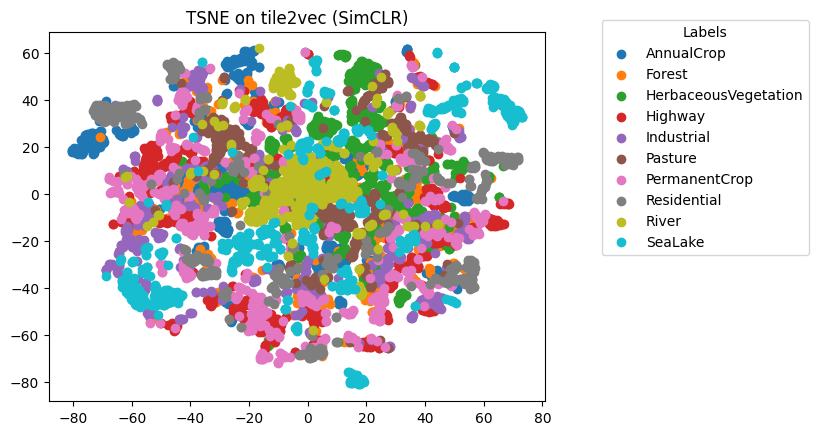

In [44]:
vizualize_tsne_2d(X, y, text = "SimCLR", perplexity = 100, random_state = 2137, n_iter = 1000)

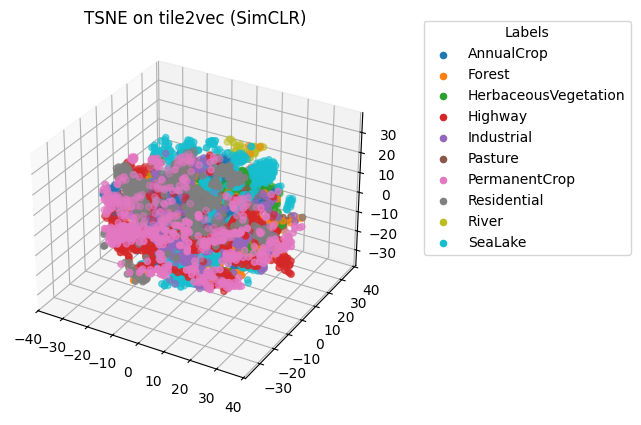

In [71]:
vizualize_tsne_3d(X, y, text = "SimCLR", perplexity = 100, random_state = 2137, n_iter = 1000)

## Divmaker training 128 dim

In [73]:
config_str = "config/eurosat/pretrain_eurosat_simclr_L1_forced.json"

system = load_from_config(config_str, "epoch=199-step=17199.ckpt")

[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.


Loaded configuration: 
{'continue_from_checkpoint': None,
 'copy_checkpoint_freq': 5,
 'cuda': True,
 'data_loader_workers': 8,
 'data_params': {'dataset': 'eurosat',
                 'normalize_before_view': True,
                 'resize_imagenet_to_32': True},
 'distributed_backend': 'dp',
 'exp_base': '/storage/divmaker/',
 'exp_name': 'pretrain_eurosat_simclr_L1_forced_budget_0.2',
 'gpu_device': 0,
 'loss_params': {'objective': 'AdversarialSimCLRLoss',
                 't': 0.07,
                 'view_maker_loss_weight': 1},
 'model_params': {'clamp_views': False,
                  'noise_dim': 100,
                  'num_res_blocks': 3,
                  'out_dim': 128,
                  'projection_head': False,
                  'resnet': True,
                  'resnet_small': True,
                  'resnet_version': 'resnet18',
                  'symmetric_clamp': True,
                  'view_L1_forced': True,
                  'view_bound_magnitude': 0.2,
               

/home/tymek/.conda/envs/divmaker/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory /storage/divmaker/experiments/pretrain_eurosat_simclr_L1_forced_budget_0.2/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Set up viewmaker model with bound magnitude: 0.2, divmaker: False
Using AdversarialSimCLRLoss
Set up viewmaker model with bound magnitude: 0.2, divmaker: False


In [74]:
X, y = create_embeddings_divmaker(system, val_dataset.dataset, z_dim=128)


100%|██████████| 5520/5520 [00:38<00:00, 144.87it/s]

Embedded 5520 tiles: 38.108s


In [75]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 94.26±0.40%


In [76]:
compare_results_kmeans(X, y)

Averaged vmeasure for model: 0.49±0.02
Averaged silhouette for model: 0.51±0.02


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


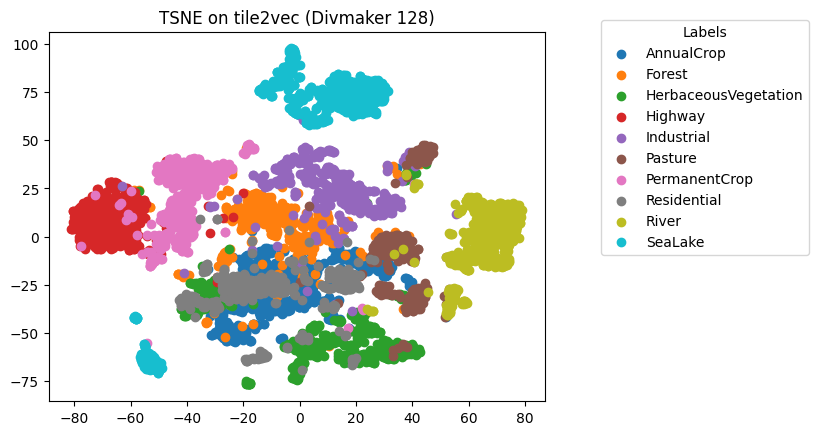

In [82]:
vizualize_tsne_2d(X, y, text = "Divmaker 128", perplexity = 30, random_state = 2137, n_iter = 1500)

## Divmaker 512

In [87]:
config_str = "config/eurosat/pretrain_eurosat_simclr_L1_forced_512.json"

system = load_from_config(config_str, "epoch=99-step=8599.ckpt")

[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories successfully set up.
[INFO]: Configurations and directories s

Loaded configuration: 
{'continue_from_checkpoint': None,
 'copy_checkpoint_freq': 5,
 'cuda': True,
 'data_loader_workers': 8,
 'data_params': {'dataset': 'eurosat',
                 'normalize_before_view': True,
                 'resize_imagenet_to_32': True},
 'distributed_backend': 'dp',
 'exp_base': '/storage/divmaker/',
 'exp_name': 'pretrain_eurosat_simclr_L1_forced_budget_0.2_512',
 'gpu_device': 0,
 'loss_params': {'objective': 'AdversarialSimCLRLoss',
                 't': 0.07,
                 'view_maker_loss_weight': 1},
 'model_params': {'clamp_views': False,
                  'noise_dim': 100,
                  'num_res_blocks': 3,
                  'out_dim': 512,
                  'projection_head': False,
                  'resnet': True,
                  'resnet_small': True,
                  'resnet_version': 'resnet18',
                  'symmetric_clamp': True,
                  'view_L1_forced': True,
                  'view_bound_magnitude': 0.2,
           

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Set up viewmaker model with bound magnitude: 0.2, divmaker: False
Using AdversarialSimCLRLoss
Set up viewmaker model with bound magnitude: 0.2, divmaker: False


In [88]:
X, y = create_embeddings_divmaker(system, val_dataset.dataset, z_dim=512)


100%|██████████| 5520/5520 [00:23<00:00, 230.23it/s]

Embedded 5520 tiles: 23.979s


In [89]:
compare_results(X, y, rf, folds = 5)

Averaged accuracy for model RandomForestClassifier: 92.83±0.60%


In [90]:
compare_results_kmeans(X, y)

Averaged vmeasure for model: 0.52±0.01
Averaged silhouette for model: 0.53±0.02


['AnnualCrop' 'Forest' 'HerbaceousVegetation' 'Highway' 'Industrial'
 'Pasture' 'PermanentCrop' 'Residential' 'River' 'SeaLake']


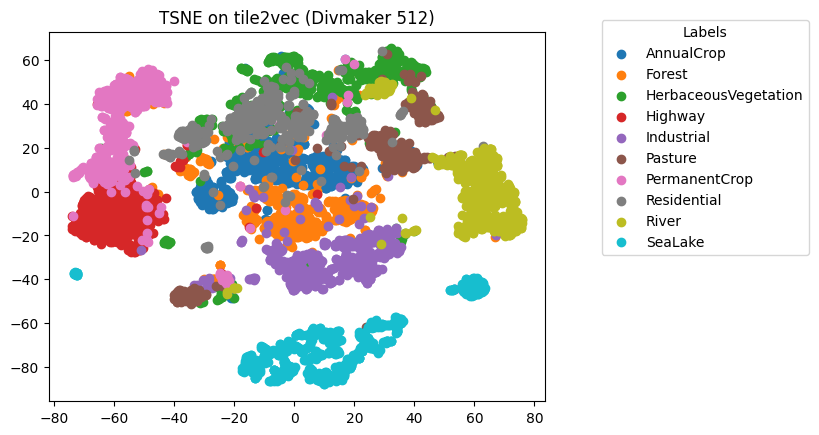

In [91]:
vizualize_tsne_2d(X, y, text = "Divmaker 512", perplexity = 30, random_state = 2137, n_iter = 1500)

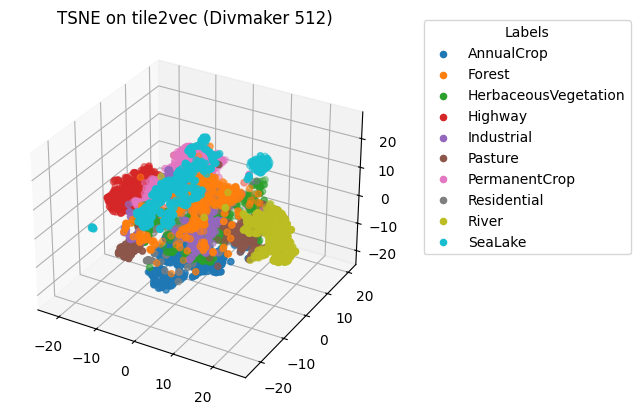

In [92]:
vizualize_tsne_3d(X, y, text = "Divmaker 512", perplexity = 30, random_state = 2137, n_iter = 1500)